---
title: "A statistical analysis of vowel inventories of world languages"
subtitle: "Multilingual NLP -- Lab 1"
author: "Philippos Triantafyllou"
date-modified: last-modified
date-format: long
lang: en
format:
    pdf:
        pdf-engine: lualatex
        documentclass: scrartcl
        fontsize: 16pt
        papersize: A3
        toccolor: blue
        classoption: 
            - "DIV=12"
            - "parskip=relative"
            - "titlepage=false"
        code-block-border-left: MediumBlue
        code-block-bg: WhiteSmoke
        template-partials:
            - "../_pandoc/doc-class.tex"
            - "../_pandoc/toc.tex"
            - "../_pandoc/before-title.tex"
toc: true
toc-depth: 3
number-depth: 1
number-sections: true
highlight-style: github
fig-cap-location: top
embed-resources: true
---

:::{.callout-note}
## Instructions

One of the aims of this practical session is to examine two well-known proposed linguistic 
universals relating to vowel systems. First, that virtually all languages possess the basic vowel triangle [i], [a], [u] (or close equivalents). Second, that if a language has highly marked vowels (for example nasal, long, or front rounded vowels), it almost always also has the corresponding simpler vowels. In this lab, we will test whether these are indeed universals by drawing on `PHOIBLE`, an open, cross-linguistic database of phonological inventories covering over 2,000 languages.

:::

In [92]:
#| echo: false
#| output: false

import os
print(os.path.basename(os.getcwd()) == 'vowel-inventories')

True


## Getting started

First glance of the dataset. Each row is a single phoneme. Phonemes are organized in unique inventories that are labelled by the variable `InventoryID`. There seems to be 3020 unique phonetic inventories. We also have some variable that correspond the inventories to world languages.

In [93]:
#| echo: false

import pandas as pd

# Load data from csv file
data = pd.read_csv("data/phoible.csv", low_memory=False).iloc[:, :10]
display(data)


,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,Phoneme,Allophones,Marginal,SegmentClass
0,1,kore1280,kor,Korean,NaN,0068,h,ç h ɦ,NaN,consonant
1,1,kore1280,kor,Korean,NaN,006A,j,j,NaN,consonant
2,1,kore1280,kor,Korean,NaN,006B,k,k̚ ɡ k,NaN,consonant
3,1,kore1280,kor,Korean,NaN,006B+02B0,kʰ,kʰ,NaN,consonant
4,1,kore1280,kor,Korean,NaN,006B+02C0,kˀ,kˀ,NaN,consonant
...,...,...,...,...,...,...,...,...,...,...
105479,3020,lamu1254,lby,Tableland Lamalama,NaN,0294,ʔ,NaN,False,consonant
105480,3020,lamu1254,lby,Tableland Lamalama,NaN,03B8,θ,NaN,False,consonant
105481,3020,lamu1254,lby,Tableland Lamalama,NaN,0061,a,NaN,False,vowel
105482,3020,lamu1254,lby,Tableland Lamalama,NaN,0069,i,NaN,False,vowel


We can have a quick look at the summary statistics of the first 10 columns (variables) that are of interest (ignoring some nonsensical information for the `InventoryID` variable for example).

In [94]:
#| label: tbl-dataset
#| tbl-cap: "Summary statistics of first 10 columns"

data.iloc[:, :10].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
InventoryID,105484.0,NaN,NaN,NaN,1479.331083,843.110759,1.0,769.0,1464.0,2237.0,3020.0
Glottocode,105465,2176,kham1282,622,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ISO6393,105459,2094,mis,828,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LanguageName,105484,2716,Iron Ossetic,444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SpecificDialect,21985,544,W2,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GlyphID,105484,3142,006D,2915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Phoneme,105484,3142,m,2915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Allophones,51904,6891,m,1091,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marginal,84610,2,False,83263,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SegmentClass,105484,3,consonant,72282,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Immediately we can see some interesting things:

- the most frequent value for `Glottocode` is `kham1282` with 622 rows;
- the most frequent value for `LanguageName` is `Iron Ossetic` with 444 rows;
- `ISO6393` has 828 values that are labelled `mis`, and we assume that they are missing values;
- amongst all the columns that correspond to language classification, there are discrepancies between their counts.

### Q1: determining the number of unique languages

:::{.callout-tip}
## FYI

In this question, we spend most of the time trying to solve the problem of multiple inventories per language. As our goal is to compute statistics over the inventories of world languages, we must make sure that each language "contributes fairly" by making sure we take it into account only once. As we will see, some languages have more than one phonetic inventory so we need to deal with this before moving further.
:::

We want to determine the number of unique languages in our dataset. Arguably, this is an important variable in our analysis so we can spend some time digging into the dataset.

A first variable that grabs our attention is `InventoryID`. When we look at the `PHOIBLE` documentation, we can see:

> For the most part, every phonological inventory in PHOIBLE is based on one-and-only-one language description (usually a research article, book chapter, dissertation, or descriptive grammar).

This seems like a coherent start to base our analysis. Each Inventory ID has a unique description of a  a phonetic inventory. But we also have other variables: `LanguageName`, `Glottocode` and `ISO6393`. Contrary to `InventoryID`, they seem to hold the "language name".

Looking at the summary statistics in the table above, we realize that the counts of these variables are not the same, that means that some values in one variable might map to multiple values in another variable and so on.

Naively, if we start form `InventoryID` and  `LanguageName`, what can we find?

We group by `LanguageName` and verify if they all (in theory they should) all have one phonological inventory.

In [95]:
subset = data.groupby("LanguageName")["InventoryID"].nunique().reset_index()
subset = subset[subset["InventoryID"] > 1]
print("Are there languages with more than one inventory?", len(subset) == 0)

Are there languages with more than one inventory? False


It seems that some languages have more than one inventory. How many languages? How many inventories do they have on average?

In [96]:
print("Number of languages with more than one phonetic inventory:", len(subset))
statistics = subset.describe().round(2).reset_index()

Number of languages with more than one phonetic inventory: 208


In [97]:
#| echo: false
#| label: tbl-inventory
#| tbl-cap: "Descriptive statistics for languages with multiple inventories"

from IPython.core.display import Markdown
statistics.columns = ["Measure", "Value"]
Markdown(statistics.to_markdown(index=False))

| Measure   |   Value |
|:----------|--------:|
| count     |  208    |
| mean      |    2.46 |
| std       |    1.01 |
| min       |    2    |
| 25%       |    2    |
| 50%       |    2    |
| 75%       |    3    |
| max       |   10    |

There are 208 languages (from the 2716 unique values in `LanguageName`) that have more than one inventory, and most of them only have one additional one. We can explain this based on the documentation description given above: presumably, different linguists have compiled slightly different inventories for the same language/dialect. There are some outliers, as there is a language with 10 inventories.

In [98]:
print(subset[subset["InventoryID"] == 10]['LanguageName'].values[0])

Iron Ossetic


Going back to the summary statistics table, there seems to be another language that has a lot of rows, this time it is the most frequent value of the `Glottocode` variable.

In [99]:
data.loc[data['Glottocode'] == 'kham1282']['InventoryID'].value_counts()

InventoryID
2519    133
2489     96
2591     78
2525     77
2587     64
2327     62
2328     61
2600     51
Name: count, dtype: int64

We can correspond this to its value(s) in the `LanguageName` variable.

In [100]:
data.loc[data['Glottocode'] == 'kham1282']['LanguageName'].unique().tolist()

['Rgyalthang Tibetan',
 'Brag-g.yab Tibetan',
 'Nangchenpa Tibetan',
 'Soghpo Tibetan',
 'Kami Tibetan',
 'Sangdam Tibetan',
 'Dongwang Tibetan',
 'Kham Tibetan']

Doing the same with `ISO6393`, we get:

In [101]:
data.loc[data['Glottocode'] == 'kham1282']['ISO6393'].unique().tolist()

['khg']

So it seems that `LanguageName` has more distinctions between "languages" and corresponds to the language name given by the linguist to the corresponding phonetic inventory.

There are are also discrepancies between the different classifications. For example concerning `LanguageName` and `Glottocode` the documentation says:

> Every phonological inventory in PHOIBLE has a unique numeric inventory ID. Since most PHOIBLE inventories (aside from some UPSID or SPA ones, as mentioned above) are based on a single document, it is fairly straightforward to link each PHOIBLE inventory to the Glottolog, which provides links between linguistic description documents and unique identifiers for dialects, languages, and groupings of dialects and languages at various levels.

Furthermore, the documentation notes differences between `Glottocode` and `LanguageName` (for example, some languages with a glottocode do not have ISO IDs, and there might be some shared ISO IDs between different glottocode IDs).

We can visualise these differences by creating a table grouping languages by the ISO norm. We can see for each ISO label, the corresponding `Glottocode` labels (if more than one), the language names given by `LanguageName` as well as the number of inventories. We only show the languages that have more than 5 different inventories.

In [102]:
subset = (
    data
    .groupby("ISO6393", as_index=False)
    .agg(
        Inventories=("InventoryID", "nunique"),
        Glottocode=("Glottocode", lambda x: ", ".join(pd.unique(x.dropna()))),
        Names=("LanguageName", lambda x: ", ".join(pd.unique(x.dropna())))
    )
    .query("Inventories >= 5")
    .sort_values("Inventories", ascending=False)
)

In [103]:
#| echo: false
#| label: tbl-discrepancies
#| tbl-cap: "Discrepancies between different language classifications"

Markdown(subset.head(10).to_markdown(index=False))

| ISO6393   |   Inventories | Glottocode                                                                                                                                                                                                                                                                   | Names                                                                                                                                                                                                                                                                                                                                                  |
|:----------|--------------:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| mis       |            30 | pisa1245, lizu1234, east2773, zhon1235, vach1239, fore1274, mink1237, guwa1244, mith1236, cola1237, yari1243, west2443, djad1246, kera1256, lowe1402, ngin1247, gudj1237, kawa1290, wala1263, tyan1235, luth1234, mbiy1238, ngko1236, yadh1237, bula1255, yulp1239, sout2770 | Pisamira, Lizu, Dolakha Newar, Zhongu Tibetan, Eastern Khanty, Forest Nenets, Minkin, Guwar, Djindewal, Mithaka, Kolakngat, Yari-Yari, East Djadjawurung, Jardwadjali, Keramin, Ngayawang, Ngintait, Gudjal, Ogh Awarrangg, Ogh Unyjan, Walangama, Thaynakwithi, Luthigh, Mbiywom, Ngkoth, Yadhaykenu, Bularnu, Yulparija, West Djadjawurung, Ngunawal |
| oss       |            12 | osse1243, digo1242                                                                                                                                                                                                                                                           | Ossetian, Iron Ossetic, Digor Ossetic                                                                                                                                                                                                                                                                                                                  |
| bzr       |            10 | biri1256                                                                                                                                                                                                                                                                     | Barna, Biri, Garingbal, Miyan, Wiri, Yambina, Yangga, Yilba, Yuwi, Wangan                                                                                                                                                                                                                                                                              |
| eng       |             9 | stan1293                                                                                                                                                                                                                                                                     | English, English (American), American English, English (Australian), English (British), English (New Zealand)                                                                                                                                                                                                                                          |
| khg       |             8 | kham1282                                                                                                                                                                                                                                                                     | Rgyalthang Tibetan, Brag-g.yab Tibetan, Nangchenpa Tibetan, Soghpo Tibetan, Kami Tibetan, Sangdam Tibetan, Dongwang Tibetan, Kham Tibetan                                                                                                                                                                                                              |
| nld       |             8 | dutc1256                                                                                                                                                                                                                                                                     | Dutch                                                                                                                                                                                                                                                                                                                                                  |
| eus       |             8 | basq1248, basq1250                                                                                                                                                                                                                                                           | Basque, BASQUE, Zuberoan Basque                                                                                                                                                                                                                                                                                                                        |
| mhr       |             7 | east2328                                                                                                                                                                                                                                                                     | Cheremis, MARI, Meadow Mari, Eastern Mari                                                                                                                                                                                                                                                                                                              |
| gup       |             7 | gunw1252, gund1246, gune1238, mura1269, guma1252, naia1238                                                                                                                                                                                                                   | Gunwinggu, Gun-Dedjnjenghmi, Gun-Djeihmi, Kune, Kuninjku, Kunwinjku, Mayali                                                                                                                                                                                                                                                                            |
| kca       |             6 | khan1273                                                                                                                                                                                                                                                                     | Ostyak, KHANTY, Eastern Khanty, Northern Khanty                                                                                                                                                                                                                                                                                                        |

Finally, let's look at how many `ISO6393` labels map to more than one `Glottocode` labels (excluding the `mis` label).

In [104]:
subset = (data.loc[data["ISO6393"] != "mis"].groupby("ISO6393")["Glottocode"].nunique())

In [105]:
#| echo: false

print("Number of ISO languages having more than one Glottocode label (excluding 'mis'):", subset.gt(1).sum())

Number of ISO languages having more than one Glottocode label (excluding 'mis'): 40


In [106]:
subset = (data.loc[data["ISO6393"] != "mis"].groupby("ISO6393")["Glottocode"].nunique())

In [107]:
#| echo: false

print("Number of ISO languages having more than two Glottocode label (excluding 'mis'):", subset.gt(2).sum())

Number of ISO languages having more than two Glottocode label (excluding 'mis'): 9


So to recap:

- since we are working with phonetic inventories, we need to keep the `InventoryID` coherent;
- a non-negligible portion of languages, especially rare languages, have more than one inventory ID;
- the number of languages varies greatly based on which classification we take;
- the two candidate variables for language name are  `ISO6393` and ` Glottocode`;
- the mismatching is minimal between the two;
- ISO has some languages classified as "missing".

We could just take the glottocode as the main language variable, but that leaves us still with the problem of multiple phonetic inventories, and that would bias our statistics, because some languages will count for at least twice. We will follow the recommendations of the dataset creators found [here](https://phoible.org/faq), that is, we wil sample one inventory per glottocode label.

> If multiple inventories per isocode/glottocode are problematic for your analysis or research question, one approach is to select one inventory from each isocode/glottocode via random sampling.

In [108]:
subset = (
    data[["InventoryID", "Glottocode"]]
    .drop_duplicates()
    .groupby("Glottocode", group_keys=False)
    .apply(lambda g: g.sample(1, random_state=42), include_groups=False)
)

sampled_data = data[data["InventoryID"].isin(subset["InventoryID"])].drop(columns=["ISO6393", "LanguageName"]).reset_index(drop=True)

In [109]:
#| echo: false
#| label: tbl-sampled
#| tbl-cap: "Sampled dataset"

display(sampled_data)

,InventoryID,Glottocode,SpecificDialect,GlyphID,Phoneme,Allophones,Marginal,SegmentClass
0,2,kett1243,NaN,0062,b,pʲ β p b,NaN,consonant
1,2,kett1243,NaN,0064,d,d d r,NaN,consonant
2,2,kett1243,NaN,0064+02B2,dʲ,dʲ,NaN,consonant
3,2,kett1243,NaN,0068,h,h,NaN,consonant
4,2,kett1243,NaN,006B+031F,k̟,ɡ k ɡ̟ k̟,NaN,consonant
...,...,...,...,...,...,...,...,...
74881,3020,lamu1254,NaN,0294,ʔ,NaN,False,consonant
74882,3020,lamu1254,NaN,03B8,θ,NaN,False,consonant
74883,3020,lamu1254,NaN,0061,a,NaN,False,vowel
74884,3020,lamu1254,NaN,0069,i,NaN,False,vowel


We can now reliably use the `Glottocode` variable to give us coherent, unique phonetic inventories for each language. Now to finally answer the original question. There are 2176 unique languages in our dataset. Looking at the average number of vowels per language, we are interested in the `SegmentClass` variable.

In [110]:
print(round(sampled_data[sampled_data['SegmentClass'] == 'vowel'].groupby('Glottocode')['Phoneme'].nunique().mean(), 2))

10.08


On average, there are 10.08 vowels per language.

In order to appreciate the distribution of the vowel inventory sizes, we also plot the distribution of the consonants.

In [111]:
# Compute vowel inventory sizes per Glottocode
vowel_inventory_sizes = (
    sampled_data[sampled_data["SegmentClass"] == "vowel"]
    .groupby("Glottocode")["Phoneme"]
    .nunique()
)

# Compute consonant inventory sizes per Glottocode
consonant_inventory_sizes = (
    sampled_data[sampled_data["SegmentClass"] == "consonant"]
    .groupby("Glottocode")["Phoneme"]
    .nunique()
)

# Group together
phoneme_inventory_sizes = (
    pd.DataFrame({
        "Vowels": vowel_inventory_sizes.value_counts().sort_index(),
        "Consonants": consonant_inventory_sizes.value_counts().sort_index()
    })
    .fillna(0)
    .astype(int)
)

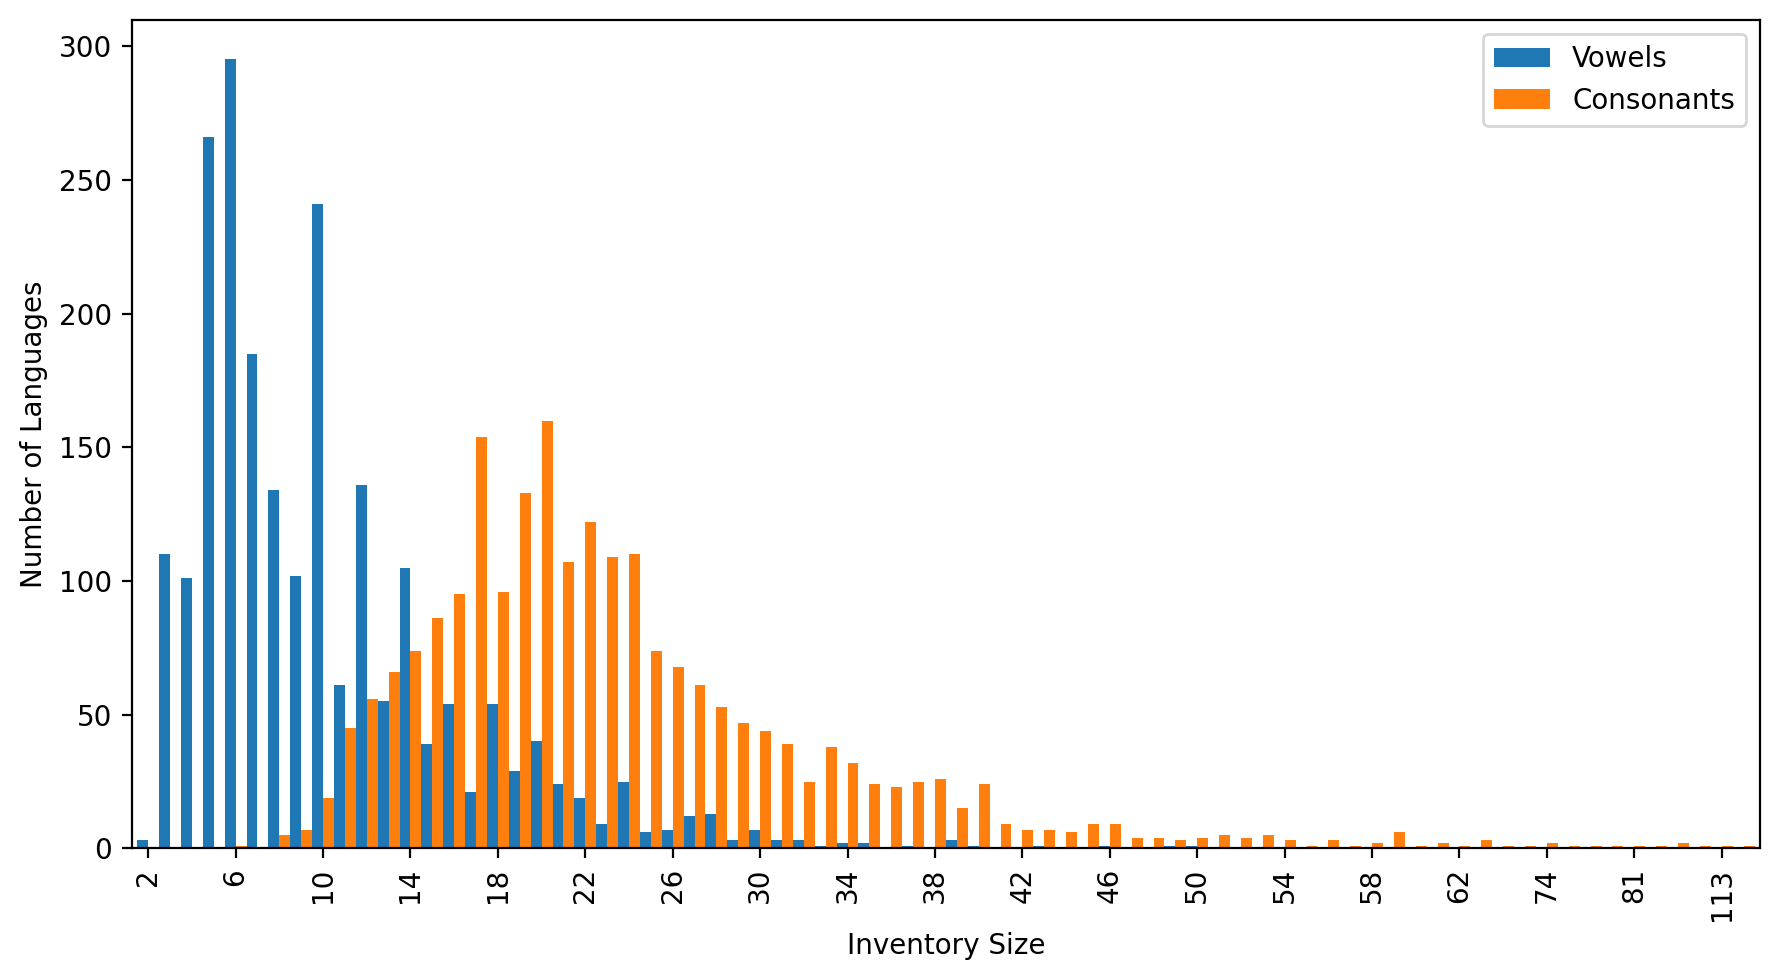

In [112]:
#| echo: false
#| label: fig-vowel-distribution
#| fig-cap: "Distribution of vowel/consonant inventory sizes across languages"

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams["figure.dpi"] = 200

# Plot side-by-side bars
ax = phoneme_inventory_sizes.plot(
    kind="bar",
    figsize=(9, 5),
    width=1,
    xlabel="Inventory Size",
    ylabel="Number of Languages"
)

# Show every 5th x-axis tick
ax.xaxis.set_major_locator(MultipleLocator(4))

plt.tight_layout()
plt.show()

 We can also compute descriptive statistics for the vowel inventory sizes.

In [113]:
#| echo: false
#| label: tbl-stat-desc-mean-vowels
#| tbl-cap: "Descriptive statistics for vowel inventory sizes"

statistics = vowel_inventory_sizes.describe().round(2).reset_index()
statistics.columns = ["Measure", "Value"]
Markdown(statistics.to_markdown(index=False))

| Measure   |   Value |
|:----------|--------:|
| count     | 2176    |
| mean      |   10.08 |
| std       |    6.12 |
| min       |    2    |
| 25%       |    6    |
| 50%       |    8    |
| 75%       |   12    |
| max       |   50    |

### Q2: what's interesting?

First, we notice a very subtle bi-modal distribution for the vowel inventories as well as the fact that it is positively skewed (the mean is higher than the median), whereas the consonant inventory sizes distribution is less dense, the sizes are on average much larger, fact that is unsurprising considering humans have more articulations for consonants.

Second, We can see from the maximal value form the descriptive statistics table that the upper bound of vowels in the human language is quite high compared to the mean. That indicates that there is an under-utilisation of the articulatory capacities of vowels.

Third, we notice that this "upper bound" is actually utilized by very few languages. As a matter of fact, there seems to be many outliers in the upper bound of our vowel distribution. This is also the case for the consonants.

### Q3: identifying outliers with the interquartile range (IQR) method

We can write a quick function that takes our `vowel_inventories` series and returns a new series with outliers.

In [114]:
def find_iqr(vowel_size: pd.Series):
    q1 = vowel_size.quantile(0.25)
    q3 = vowel_size.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = ~vowel_size.between(lower, upper)
    return vowel_size[mask]

We get 121 outliers.

In [115]:
#| echo: false
#| label: tbl-iqr-outliers
#| tbl-cap: "List of outliers using IQR"

subset = vowel_inventory_sizes.sort_values(ascending=False)
subset = find_iqr(subset).reset_index()
display(subset)

,Glottocode,Phoneme
0,elfd1234,50
1,scot1245,49
2,juho1239,46
3,para1301,43
4,reel1238,40
...,...,...
116,adan1251,22
117,dhim1246,22
118,doya1240,22
119,teng1272,22


We can now plot the distributions again, this time removing the outliers.

In [116]:
# Compute vowel inventory sizes per Glottocode
vowel_inventory_sizes = (
    sampled_data[sampled_data["SegmentClass"] == "vowel"]
    .groupby("Glottocode")["Phoneme"]
    .nunique()
)

# Compute consonant inventory sizes per Glottocode
consonant_inventory_sizes = (
    sampled_data[sampled_data["SegmentClass"] == "consonant"]
    .groupby("Glottocode")["Phoneme"]
    .nunique()
)

# Remove outliers
vowel_outliers = find_iqr(vowel_inventory_sizes.sort_values(ascending=False))
consonant_outliers = find_iqr(consonant_inventory_sizes.sort_values(ascending=False))
vowel_inventory_sizes = vowel_inventory_sizes.drop(index=vowel_outliers.index)
consonant_inventory_sizes = consonant_inventory_sizes.drop(consonant_outliers.index)

# Align both distributions on the same x-axis (fill missing sizes with 0)
phoneme_inventory_sizes = (
    pd.DataFrame({
        "Vowels": vowel_inventory_sizes.value_counts().sort_index(),
        "Consonants": consonant_inventory_sizes.value_counts().sort_index()
    })
    .fillna(0)
    .astype(int)
)

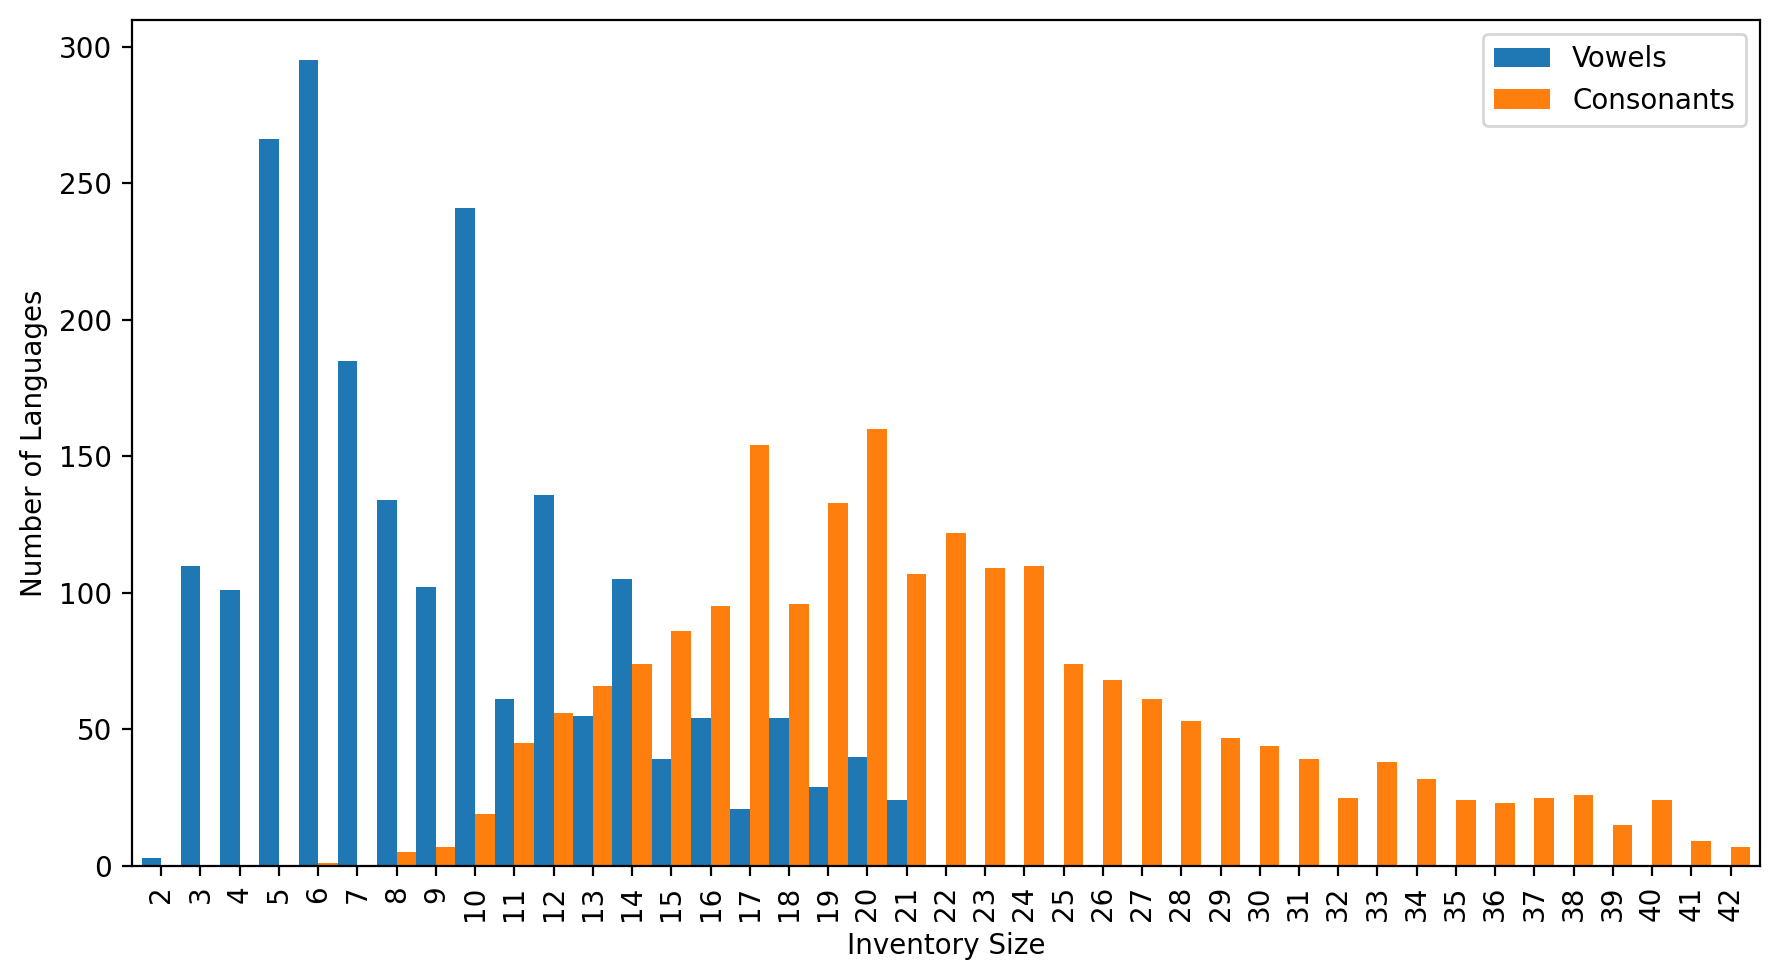

In [117]:
#| echo: false
#| label: fig-vowel-distribution-2
#| fig-cap: "Distribution of vowel/consonant inventory sizes across languages (without outliers)"

# Plot side-by-side bars
phoneme_inventory_sizes.plot(
    kind="bar",
    figsize=(9, 5),
    width=1,
    xlabel="Inventory Size",
    ylabel="Number of Languages"
)

plt.tight_layout()
plt.show()

We can compute the statistics again.

In [118]:
#| echo: false
#| label: tbl-stat-desc-mean-vowels-no-outliers
#| tbl-cap: "Descriptive statistics for vowel inventory sizes (without outliers)"

statistics = vowel_inventory_sizes.describe().round(2).reset_index()
statistics.columns = ["Measure", "Value"]
Markdown(statistics.to_markdown(index=False))

| Measure   |   Value |
|:----------|--------:|
| count     | 2055    |
| mean      |    9.08 |
| std       |    4.44 |
| min       |    2    |
| 25%       |    6    |
| 50%       |    8    |
| 75%       |   12    |
| max       |   21    |

Even when removing outliers, we can see that the positive skew remains. We can conclude that most languages use a small set of vowels in their phonological systems. This leads to the following questions?

- What are these vowels?
- Are they on average the same between languages?
- Can we identify the basic vowel triangle for all of them?

## Testing linguistic universals

:::{.callout-note}
## Instructions

The basic idea of this part is to use the data to test whether the proposed universals are actually observed across the sample of languages in the `PHOIBLE` database.

Mutual information formula:

$$
I(A, B) = \sum_{a \in \{0,1\}} \sum_{b \in \{0,1\}} 
p(a,b) \log \frac{p(a,b)}{p(a)\,p(b)}
$$

Where $p(a,b)$ is the proportion of languages with the configuration $(a,b)$, and $p(a)$ and
$p(b)$ are the marginal probabilities of each phoneme.
:::

### Q4: identify the three most frequent vowels

We create a subset of our data with only the vowels.

In [119]:
vowels = sampled_data[sampled_data['SegmentClass'] == 'vowel'].reset_index(drop=True)

In order to answer this question, we must first convene how we will measure vowels. We could for example follow the composition of the phonetic inventories and count each row (each phonemes) individually. A consequence of this would be a distinction between [a] and [aː]. One could argue that in the hypothetical case where a language possesses the phoneme [aː] but not [a] can be considered part of the set of languages with the basic vowel triangle (assuming [u] and [i] are also present).

In phonetics, there is the distinctions between monophthongs, diphthongs, triphthongs, and of course the previous example of diacritics. To show this, let's consider many distinct phonemes there exist within our data, that are composed in part by the sound [a]. In order to do this, we will use the `GlyphID` variable and select all values that contain the Unicode for [a], that is `U0061`.

In [120]:
print(vowels[vowels["GlyphID"].astype(str).str.contains("0061", na=False)]["Phoneme"].unique())

['a' 'aː' 'ã' 'ãː' 'a̟' 'a̟̙ː' 'a̟ː' 'ã̟' 'ã̟ː' 'ai' 'au' 'aˤ' 'a̤'
 'a˞' 'aɯ' 'a̰' 'aɨ' 'ă' 'ḁ' 'ae̞' 'a̟i' 'ã̟ĩ' 'ia' 'ua' 'ɨa' 'ae̞ˤ'
 'ao̞' 'ao̞ˤ' 'aˤː' 'ãẽ̞ˤ' 'ãõ̞ˤ' 'ãˤ' 'ãˤː' 'o̞a' 'o̞aˤ' 'õ̞ã'
 'õ̞ãˤ' 'ã̰' 'ɯa' 'a̤i̤' 'a̤ṳ' 'a̤ɯ̤' 'i̤a̤' 'ṳa̤' 'a̠' 'a̠ː' 'iaː'
 'uaː' 'ao' 'i̯a' 'ay' 'ae' 'ea' 'iã' 'ɪa' 'ɪã' 'ʊa' 'iau' 'uai' 'aɪ'
 'aʊ' 'aˀ' 'oa' 'aɛ' 'ãi' 'a̙' 'a̙ː' 'a̙ˠ' 'aɔ' 'a̰ḭ' 'a̰ṵ' 'a̤ː' 'a̤ˑ'
 'a̰ː' 'a̰ˑ' 'uːa' 'aˑ' 'aᴱ' 'å' 'i̯ãː' 'uã' 'uãː' 'au̯' 'ai̯' 'ä'
 'aʲ' 'aʲː' 'au̜' 'aʊɪ' 'ya' 'əɪa' 'äː' 'ɔaː' 'ae̯' 'o̞ä' 'uä' 'äi̯'
 'äu̯' 'u̯a' 'ãĩ' 'ãũ' 'ã̈' 'ɔa' 'ɛa' 'ä̠' 'aːu' 'ɪ̯ä' 'ã̈ː'
 'ã̤̈ː' 'ä̤' 'ai̯ː' 'auː' 'ãɪ̯ː' 'i̯au̯' 'a˞ː' 'a˞ˤ' 'aɪ̃' 'aɯ̃' 'a̰ɪ̰'
 'a̰ɯ̰' 'oä' 'aːi̯' 'ãɛ̃' 'aɵ̯' 'ua̟' 'ɛa̟' 'u̯ã' 'ĩã' 'aːu̯' 'ũã'
 'aːi' 'ã̤']


As we can see, there are *a lot* of cases: the "stable" vowel [a] is also present with diacritics, modifiers and as part of diphthongs (for example [ai] and [a̤ṳ]) and some triphthongs (for example [aʊɪ] or [əɪa]).

Can w then consider that a language with the phoneme [əɪa] (and not the phoneme [a]), should be excluded from the languages with the basic vowel triangle? Our intuitive answer is no, but this would require a thorough phonological investigation, that is beyond the scope of this work.

We can nonetheless try to find such cases, where a language has an inventory excluding the stable vowel [a], but has other(s) that combine this sound with others.

In [121]:
subset = (
    vowels.assign(
        has_plain = (vowels["GlyphID"].eq("0061")),
        has_variant = (vowels["GlyphID"].str.match(r"(^|\+)0061(\+|$)", na=False) & ~vowels["GlyphID"].eq("0061"))
    )
)

subset = (
    subset
    .groupby("InventoryID", as_index=False)[["has_plain", "has_variant"]]
    .any().query("has_variant and not has_plain")
)

print(subset["InventoryID"].tolist())

[14, 49, 57, 93, 141, 150, 155, 157, 166, 187, 193, 198, 304, 307, 331, 336, 354, 358, 390, 391, 409, 413, 427, 489, 502, 510, 516, 540, 545, 566, 568, 576, 585, 861, 965, 997, 1041, 1142, 1309, 1326, 1414, 1554, 1716, 1733, 1767, 1796, 2169, 2221, 2245, 2250, 2252, 2253, 2256, 2260, 2266, 2270, 2278, 2285, 2291, 2304, 2315, 2325, 2331, 2336, 2337, 2348, 2358, 2363, 2365, 2375, 2381, 2384, 2386, 2392, 2394, 2397, 2404, 2412, 2447, 2452, 2453, 2464, 2466, 2473, 2474, 2485, 2491, 2493, 2494, 2498, 2499, 2514, 2541, 2545, 2546, 2552, 2564, 2565, 2566, 2568, 2570, 2571, 2575, 2580, 2593, 2596, 2602, 2604, 2608, 2616, 2619, 2625]


There are indeed languages! 112 to be precise. We can have a look at one's vowel inventory.

In [122]:
print(vowels.loc[vowels["InventoryID"] == 14, "Phoneme"].tolist())

['a̟', 'a̟̙ː', 'ei̙', 'e̘ː', 'iː', 'ou̙', 'o̘ː', 'uː', 'ɒ', 'ɒː', 'ɔ', 'ɔ̘ː', 'ə', 'əɨ̙', 'ə̘ː', 'ɛ', 'ɛ̘ː', 'ɨː', 'ɪ', 'ɪ̈', 'ʊ']


We can see that this inventory has phonemes such as [a̟] and [a̟̙ː], and one could argue that such a language can be included in the set of languages that possess the basic vowel triangle.

In order to properly achieve this, we would need to have a phonetically informed method of aggregating candidate vowels. For example, how would we deal with the case [ai], is it [a], [i], or both?. That would also imply working with the glyphs as above. The current state of the data provide a phonological distinction between different units: in a single inventory [a] and [aː] are distinct because they are meaningful units of sound. As such, sticking to the original intuition and *not* taking into account the diacritics is the best choice for now.

Now, going back to computing the most frequent vowels.

In [123]:
vowel_frequencies = vowels.groupby('Phoneme')['Glottocode'].nunique().sort_values(ascending=False).reset_index()

In [124]:
#| echo: false
#| label: tbl-most-frequent-vowels
#| tbl-cap: "Most frequent vowels across all languages"

vowel_frequencies.columns = ["Vowel", "Num. of inventories"]
Markdown(vowel_frequencies.head(10).to_markdown(index=False))

| Vowel   |   Num. of inventories |
|:--------|----------------------:|
| i       |                  2032 |
| u       |                  1940 |
| a       |                  1925 |
| e       |                  1399 |
| o       |                  1371 |
| ɛ       |                   796 |
| ɔ       |                   767 |
| iː      |                   713 |
| aː      |                   678 |
| uː      |                   661 |

It seems that when we look across all languages, the most frequent vowels are those of the triangle. The most frequent vowel is [i], followed by [u] and [a]. We can also recognize that amongst the top 10 vowels "universally", the last three positions are elongated versions of the first ones, confirming our thoughts previously, about the importance of taking into account the diacritics...

As an intermediary solution we can take a subset of the vowels, keeping only the so called "stable" vowels or the monophthongs.

We first find all our vowels.

In [176]:
print(vowels["Phoneme"].unique().tolist()[:50])

['a', 'i', 'æ', 'ɔ', 'ɨ', 'ʊ', 'u', 'ə', 'e', 'o', 'ɒ', 'ɛ', 'ɪ', 'ɘ', 'ɑ', 'ɐ', 'ɯ', 'ɤ', 'ʌ', 'ø', 'ɜ', 'y', 'ʉ', 'ʏ', 'œ', 'ɞ', 'ɵ', 'ɶ']


Then get their glyph IDs.

In [177]:
print(vowels["GlyphID"].unique().tolist()[:50])

['0061', '0069', '00E6', '0254', '0268', '028A', '0075', '0259', '0065', '006F', '0252', '025B', '026A', '0258', '0251', '0250', '026F', '0264', '028C', '00F8', '025C', '0079', '0289', '028F', '0153', '025E', '0275', '0276']


A very simple "trick", would be to select the codes that only have one glyph, that would be the base monophthong.

In [127]:
print(vowels[vowels["GlyphID"].str.match(r"^[^+]+$", na=False)]["Phoneme"].unique().tolist())

['a', 'i', 'æ', 'ɔ', 'ɨ', 'ʊ', 'u', 'ə', 'e', 'o', 'ɒ', 'ɛ', 'ɪ', 'ɘ', 'ɑ', 'ɐ', 'ɯ', 'ɤ', 'ʌ', 'ø', 'ɜ', 'y', 'ʉ', 'ʏ', 'œ', 'ɞ', 'ɵ', 'ɶ']


We can build a new subset of monophthong vowels.

In [128]:
vowels = vowels[~vowels["GlyphID"].str.contains(r"\+", na=False)].reset_index(drop=True)

In [129]:
#| echo: false

display(vowels)

,InventoryID,Glottocode,SpecificDialect,GlyphID,Phoneme,Allophones,Marginal,SegmentClass
0,2,kett1243,NaN,0061,a,a̟ a,NaN,vowel
1,2,kett1243,NaN,0069,i,i ɪ i,NaN,vowel
2,2,kett1243,NaN,00E6,æ,ɛ æ æ e,NaN,vowel
3,2,kett1243,NaN,0254,ɔ,o ɔ ø,NaN,vowel
4,2,kett1243,NaN,0268,ɨ,ɨ,NaN,vowel
...,...,...,...,...,...,...,...,...
12632,3019,werg1234,NaN,0069,i,NaN,False,vowel
12633,3019,werg1234,NaN,0075,u,NaN,False,vowel
12634,3020,lamu1254,NaN,0061,a,NaN,False,vowel
12635,3020,lamu1254,NaN,0069,i,NaN,False,vowel


We can recompute the most frequent vowels again.

In [130]:
vowel_frequencies = vowels.groupby('Phoneme')['Glottocode'].nunique().sort_values(ascending=False).reset_index()

In [131]:
#| echo: false
#| label: tbl-most-frequent-monophthongs
#| tbl-cap: "Most frequent (stable) vowels across all languages"

vowel_frequencies.columns = ["Vowel", "Num. of inventories"]
Markdown(vowel_frequencies.head(10).to_markdown(index=False))

| Vowel   |   Num. of inventories |
|:--------|----------------------:|
| i       |                  2032 |
| u       |                  1940 |
| a       |                  1925 |
| e       |                  1399 |
| o       |                  1371 |
| ɛ       |                   796 |
| ɔ       |                   767 |
| ə       |                   462 |
| ɨ       |                   361 |
| ɪ       |                   308 |

We can see that there are new arrivals in the top 10, including the formidable schwa.

### Q5: compute the proposition of languages that contain vowels form the basic triangle

We define a dummy function to avoid cluttering with new variables.

In [132]:
def foo(data: pd.DataFrame, pattern = ['a', 'u', 'i']):
    inventories_per_language = data.groupby("Glottocode")["Phoneme"].apply(set)
    subset = inventories_per_language.apply(lambda inventory: set(pattern).issubset(inventory)).sum()
    total = data['Glottocode'].nunique()
    return (subset / total) * 100

In [133]:
#| echo: false

print(f"{foo(vowels):.2f}%")

79.42%


The answer does not support universals. There is a fifth of the world languages that do not have the basic phonetic triangle, even if our definition is fairly strict. What we can say is that a strong majority of languages do posses the triangle. 

### Q6: constructing a contingency table

Let us first have a list of all unique consonants.

In [179]:
consonants = sampled_data[sampled_data['SegmentClass'] == 'consonant'].reset_index(drop=True)
print(consonants["Phoneme"].unique().tolist()[:50])
print(consonants["GlyphID"].unique().tolist()[:50])

['b', 'd', 'dʲ', 'h', 'k̟', 'lʲ', 'lˠ', 'm', 'n', 'nʲ', 'q', 's', 'sʲ', 't', 'tʲ', 'ŋ', 'ʔ', 'ʝ', 'j', 'kʰ', 'kʷʰ', 'kʷʼ', 'kʼ', 'k͈', 'k͈ʷ', 'l', 'pʰ', 'pʼ', 'p͈', 'qʰ', 'qʷʰ', 'qʷʼ', 'qʼ', 'q͈', 'q͈ʷ', 'r', 's͈', 'tsʰ', 'tsʷʰ', 'tsʷʼ', 'tsʼ', 'tʰ', 'tʼ', 't̠ʃʰ', 't̠ʃʷʰ', 't̠ʃʷʼ', 't̠ʃʼ', 't̠͈ʃ', 't̠͈ʃʷ', 't͈']
['0062', '0064', '0064+02B2', '0068', '006B+031F', '006C+02B2', '006C+02E0', '006D', '006E', '006E+02B2', '0071', '0073', '0073+02B2', '0074', '0074+02B2', '014B', '0294', '029D', '006A', '006B+02B0', '006B+02B7+02B0', '006B+02B7+02BC', '006B+02BC', '006B+0348', '006B+0348+02B7', '006C', '0070+02B0', '0070+02BC', '0070+0348', '0071+02B0', '0071+02B7+02B0', '0071+02B7+02BC', '0071+02BC', '0071+0348', '0071+0348+02B7', '0072', '0073+0348', '0074+0073+02B0', '0074+0073+02B7+02B0', '0074+0073+02B7+02BC', '0074+0073+02BC', '0074+02B0', '0074+02BC', '0074+0320+0283+02B0', '0074+0320+0283+02B7+02B0', '0074+0320+0283+02B7+02BC', '0074+0320+0283+02BC', '0074+0320+0348+0283', '0074+0320+

We have a lot of consonants...

In [135]:
print(len(consonants["Phoneme"].unique().tolist()))

1682


We can also have a quick look at the consonant frequencies.

In [136]:
consonant_frequencies = consonants.groupby('Phoneme')['Glottocode'].nunique().sort_values(ascending=False).reset_index()

In [137]:
#| echo: false
#| label: tbl-most-frequent-consonants
#| tbl-cap: "Most frequent consonants across all languages"

consonant_frequencies.columns = ["Consonant", "Num. of inventories"]
Markdown(consonant_frequencies.head(10).to_markdown(index=False))

| Consonant   |   Num. of inventories |
|:------------|----------------------:|
| m           |                  2102 |
| k           |                  1970 |
| j           |                  1957 |
| p           |                  1857 |
| w           |                  1842 |
| n           |                  1729 |
| t           |                  1547 |
| l           |                  1479 |
| s           |                  1449 |
| ŋ           |                  1386 |

We must construct a 2 × 2 contingency table indicating, for each language in the dataset:

- whether it has phoneme A;
- whether it has phoneme B;

The four cells of the table will then correspond to: (A present & B present), (A present & B absent), (A absent & B present), (A absent & B absent).

We can first have a look at the size of the data we are working with, namely the number of phonemes, the number of unique combinations and the incidence matrix dimensions.

In [138]:
from itertools import combinations

phonemes_set = set(sampled_data['Phoneme'].unique())
print(f"Number of unique phonemes: {len(phonemes_set)}")

phoneme_pairs = list(combinations(phonemes_set, 2))
print(f"Number of possible combinations for phoneme pairs: {len(phoneme_pairs)}")

matrix = pd.crosstab(sampled_data['Glottocode'], sampled_data['Phoneme'])
print(f"Incidence matrix size: {matrix.shape}")

Number of unique phonemes: 2567
Number of possible combinations for phoneme pairs: 3293461
Incidence matrix size: (2176, 2567)


We have *a lot* of combinations. 

We have previously made the choice to reduce the set of vowels to the monophthongs. To further simplify computations (in the hope of reducing the three million possible combinations), we will restrict our consonants to pulmonic consonants. Most languages in the world *only* have pulmonic consonants. The few languages that have either ejective, implosive or click consonants (or a combination), usually also have pulmonic consonants as well. To see if our choice excludes any language by default, we can do a quick test.

We try to find any language that has consonants *other than* pulmonic ones (we take pulmonic consonants according to the IPA chart found [here](https://www.internationalphoneticassociation.org/sites/default/files/phonsymbol.pdf)).

In [178]:
pulmonic_consonants_utf = [
    '0070','0062','006D','0299','0278','03B2','0271','2C71','0066','0076','028B',
    '0074','0064','006E','0072','027E','03B8','00F0','0073','007A','0283','0292',
    '026C','026E','0279','006C','0288','0256','0273','027D','0282','0290','027B',
    '026D','0063','025F','0272','00E7','029D','006A','028E','006B','0261','014B',
    '0078','0263','0270','029F','0071','0262','0274','0280','03C7','0281','0127',
    '0295','0294','0068','0266'
]

print(consonants[consonants["GlyphID"].isin(pulmonic_consonants_utf)]["Phoneme"].unique().tolist()[:50])

['b', 'd', 'h', 'm', 'n', 'q', 's', 't', 'ŋ', 'ʔ', 'ʝ', 'j', 'l', 'r', 'x', 'z', 'ħ', 'ɡ', 'ɢ', 'ʃ', 'ʒ', 'χ', 'k', 'p', 'ɖ', 'ɳ', 'ʈ', 'v', 'ɭ', 'ɽ', 'ʂ', 'ɲ', 'ʋ', 'f', 'ɣ', 'ɾ', 'c', 'β', 'ʀ', 'ɻ', 'ð', 'ɹ', 'ɬ', 'ɰ', 'ɸ', 'θ', 'ɟ', 'ʎ', 'ʐ', 'ʁ']


In [140]:
subset = consonants.assign(pulmonic = (consonants["GlyphID"].isin(pulmonic_consonants_utf)))
subset = subset.groupby("InventoryID", as_index=False)["pulmonic"].any()
print(len(subset) == len(consonants["Glottocode"].unique()))

True


Its clear that there are no languages that have no pulmonic consonants, so we are not excluding by default any language from our analysis. We have just restricted our search to "stable" vowels and pulmonic consonants. We are aware that this choice weakens our analysis on universals, but at least it would remain consistent. The correct way would require a more in-depth phonological analysis, that is again beyond the scope of this work. We hope that phonologists and phoneticians would forgive us...

We can apply these filters and recompute the number of possible combinations.

In [141]:
vowel_mask = (
    (sampled_data["SegmentClass"] == "vowel")
    & ~sampled_data["GlyphID"].str.contains(r"\+", na=False)
)

consonant_mask = (
    (sampled_data["SegmentClass"] == "consonant")
    & sampled_data["GlyphID"].isin(pulmonic_consonants_utf)
)

filtered_data = sampled_data.loc[vowel_mask | consonant_mask].reset_index(drop=True)

In [142]:
#| echo: false

display(filtered_data)

,InventoryID,Glottocode,SpecificDialect,GlyphID,Phoneme,Allophones,Marginal,SegmentClass
0,2,kett1243,NaN,0062,b,pʲ β p b,NaN,consonant
1,2,kett1243,NaN,0064,d,d d r,NaN,consonant
2,2,kett1243,NaN,0068,h,h,NaN,consonant
3,2,kett1243,NaN,006D,m,m m̥,NaN,consonant
4,2,kett1243,NaN,006E,n,n n̥,NaN,consonant
...,...,...,...,...,...,...,...,...
43893,3020,lamu1254,NaN,0294,ʔ,NaN,False,consonant
43894,3020,lamu1254,NaN,03B8,θ,NaN,False,consonant
43895,3020,lamu1254,NaN,0061,a,NaN,False,vowel
43896,3020,lamu1254,NaN,0069,i,NaN,False,vowel


In [143]:
phonemes_set = set(filtered_data['Phoneme'].unique())
print(f"Number of unique phonemes: {len(phonemes_set)}")

phoneme_pairs = list(combinations(phonemes_set, 2))
print(f"Number of possible combinations for phoneme pairs: {len(phoneme_pairs)}")

matrix = pd.crosstab(filtered_data['Glottocode'], filtered_data['Phoneme'])
print(f"Incidence matrix size: {matrix.shape}")

Number of unique phonemes: 87
Number of possible combinations for phoneme pairs: 3741
Incidence matrix size: (2176, 87)


We have considerably reduced the size of our data.

Now we can use the `phoneme_pairs` and `matrix` (the incidence matrix of each phoneme in each language); to build our contingency tables efficiently.

In [144]:
from tqdm import tqdm
import numpy as np

def build_contingencies(matrix, pairs):
    contingencies = {}

    for a, b in tqdm(pairs, desc="Building contingency tables"):
        a, b = sorted([a, b])
        x, y = matrix[a].astype(bool), matrix[b].astype(bool)
        table = np.array([[(x & y).sum(), (x & ~y).sum()], [(~x & y).sum(),  (~x & ~y).sum()]])
        contingencies[(a, b)] = table
    
    return contingencies

contingencies = build_contingencies(matrix, phoneme_pairs)

Building contingency tables: 100%|██████████| 3741/3741 [00:00<00:00, 5984.20it/s]


In [145]:
print(f"Example contingency table for pair (a, u): \n{contingencies[('a','u')]}")

Example contingency table for pair (a, u): 
[[1742  183]
 [ 198   53]]


In [146]:
#| echo: false
#| output: false

# Quick manual check
# languages that have 'a'
langs_with_a = set(filtered_data.loc[filtered_data['Phoneme'] == 'a', 'Glottocode'])

# languages that have 'u'
langs_with_u = set(filtered_data.loc[filtered_data['Phoneme'] == 'u', 'Glottocode'])

# all languages
all_langs = set(filtered_data['Glottocode'])

# languages with neither 'a' nor 'u'
langs_without_a_u = all_langs - (langs_with_a | langs_with_u)

print("Languages without 'a' and 'u':", len(langs_without_a_u))

del langs_with_a, langs_with_u, all_langs, langs_without_a_u

Languages without 'a' and 'u': 53


### Q7: compute a chi-square test of independence on this table

To compute the chi-squared tests, we can use the `chi2_contingency` method form `scipy`. We write create a quick function.

In [147]:
#| output: false

from scipy.stats import chi2_contingency

def compute_chi(contingencies):
    chi2_results = {}

    for pair, table in tqdm(contingencies.items(), desc="Calculating chi-2"):
        chi2, p, dof, expected = chi2_contingency(table)
        chi2_results[pair] = {
            "chi2": chi2,
            "p": p,
            "dof": dof,
            "expected": expected
        }

    return chi2_results

chi2_results = compute_chi(contingencies)

Calculating chi-2: 100%|██████████| 3741/3741 [00:00<00:00, 13631.74it/s]


In [148]:
#| echo: false

print("Chi squared statistics for the pair (a, u):")
print("Chi:", chi2_results[('a', 'u')]['chi2'])
print("p-value:", chi2_results[('a', 'u')]['p'])
print("Expected co-occurrence table under H0:\n", chi2_results[('a', 'u')]['expected'])

Chi squared statistics for the pair (a, u):
Chi: 29.75974801600323
p-value: 4.8904106341758094e-08
Expected co-occurrence table under H0:
 [[1716.22242647  208.77757353]
 [ 223.77757353   27.22242647]]


We can see that for the pair (a, u), the chi-squared test detects dependence, but the expected co-occurrence counts (under the independence hypothesis) are not so far off from the actual counts. This can indicate that although there is an effect, this effect is not very large.

To have a general overview of the dependence/independence of phoneme pairs, we can plot the p_values distribution. If there is a skewness towards 0, this would indicate strong dependencies, if not, this would indicate that phonemes generally occur independently form one another.

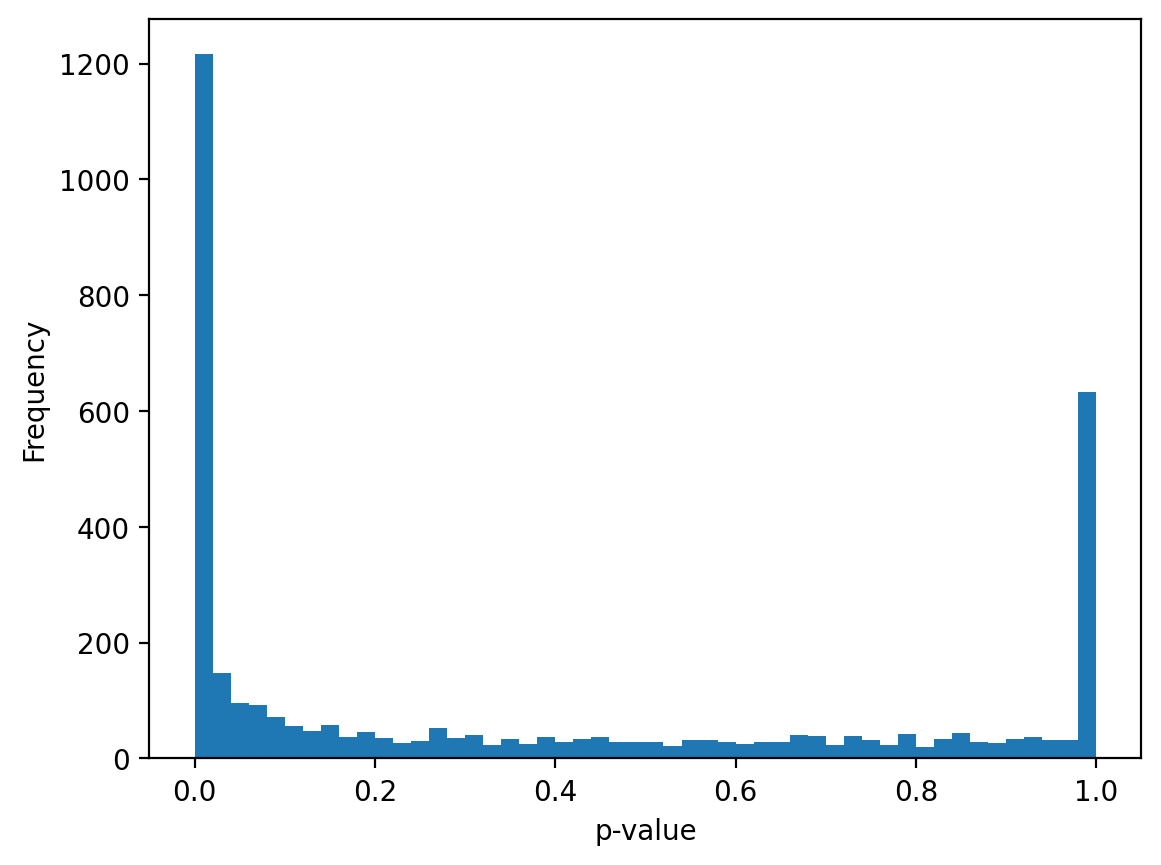

In [149]:
#| echo: false
#| label: fig-chi-distribution
# | fig-cap: "Distribution of chi-square test p-values across phoneme pairs"

plt.hist([pair['p'] for pair in chi2_results.values()], bins=50)
plt.xlabel("p-value")
plt.ylabel("Frequency")
plt.show()

The results strongly suggest that most phoneme occurrences depend on other phonemes. We can see that for most cases the p-values are closer to 0. But we can also see a small set of phoneme pairs that show no dependency. That would indicate that phonemes have "preferred partners" with whom they occur together.

### Q8: compute the mutual information between the two phonemes

In [150]:
#| output: false

def mi(contingencies):
    mi_results = {}

    for pair, table in tqdm(contingencies.items(), desc="Calculating mutual information"):
        a, b = int(table[0, 0]), int(table[0, 1])
        c, d = int(table[1, 0]), int(table[1, 1])
        N = a + b + c + d
        if N == 0:
            mi_results[pair] = 0.0
            continue

        # Marginals
        pa1 = (a + b) / N; pa0 = (c + d) / N
        pb1 = (a + c) / N; pb0 = (b + d) / N

        I = 0.0
        if a > 0: I += (a / N) * np.log2((a / N) / (pa1 * pb1))
        if b > 0: I += (b / N) * np.log2((b / N) / (pa1 * pb0))
        if c > 0: I += (c / N) * np.log2((c / N) / (pa0 * pb1))
        if d > 0: I += (d / N) * np.log2((d / N) / (pa0 * pb0))

        mi_results[pair] = I
    
    return mi_results

mutual_information = mi(contingencies)

Calculating mutual information:   0%|          | 0/3741 [00:00<?, ?it/s]

Calculating mutual information: 100%|██████████| 3741/3741 [00:00<00:00, 341953.78it/s]


In [151]:
# echo: false

print(f"Example mutual information for pair (a, u): \n{mutual_information[('a', 'u')]}")

Example mutual information for pair (a, u): 
0.008574494873149513


The results here confirm our intuition previously, the mutual information between the phonemes [a] and [u] is positive by small (close to zero). By this metric, we would be more inclined to conclude that there is an independence between them. We can also plot these results and have a general overview.

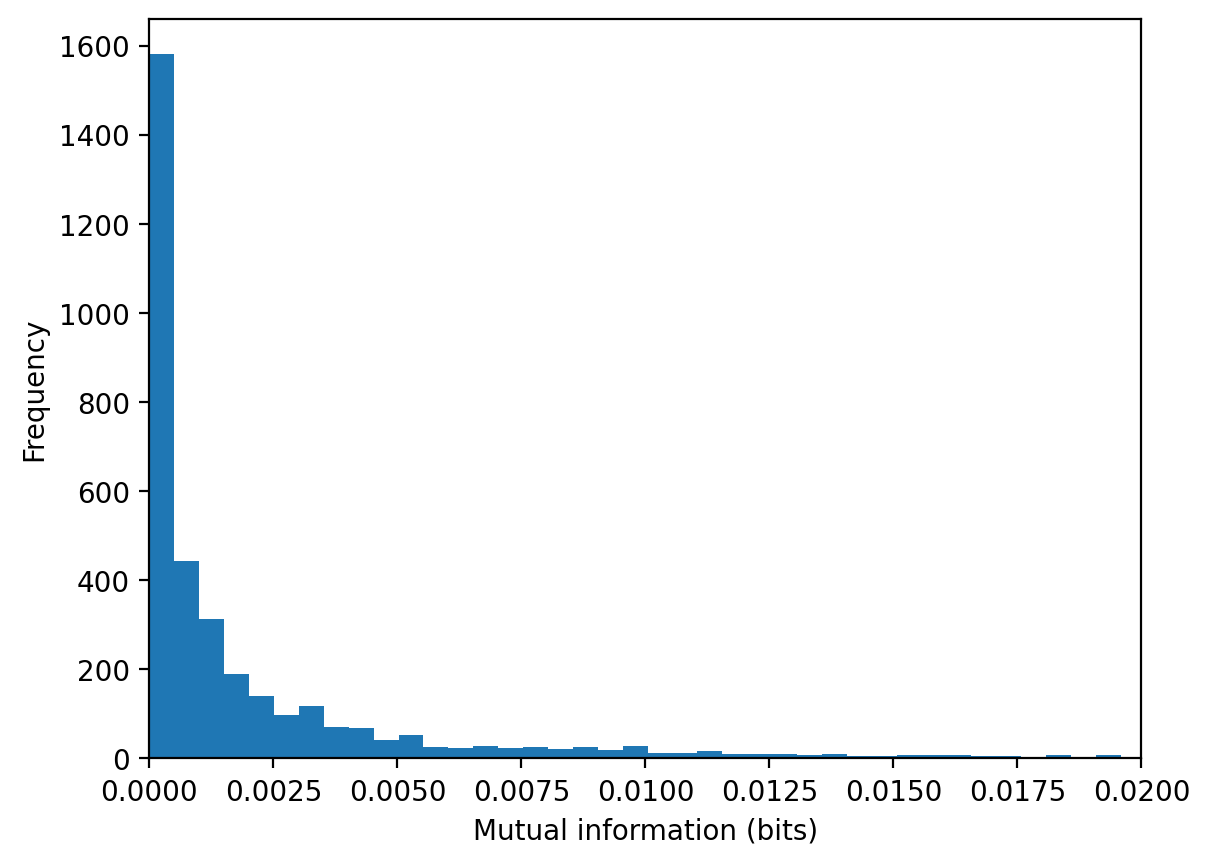

In [152]:
#| echo: false
#| label: fig-mi
#| fig-cap: "Distribution of mutual information between phoneme pairs"


plt.hist([val for val in mutual_information.values()], bins=1000)
plt.xlim(0, 0.02)
plt.xlabel("Mutual information (bits)")
plt.ylabel("Frequency")
plt.show()

We see that most pairs' mutual information is close to zero, indicating that there is an independence between their occurrences...

### Q9: do the two methods lead to similar conclusions about the relationship between the two phonemes?

We can plot both results and see their relationship.

In [153]:
df = pd.DataFrame([
    {
        "pair": pair,
        "minus_log10_p": -np.log10(max(res["p"], 1e-300)),
        "MI": mutual_information.get(pair, np.nan)
    }
    for pair, res in chi2_results.items()
])

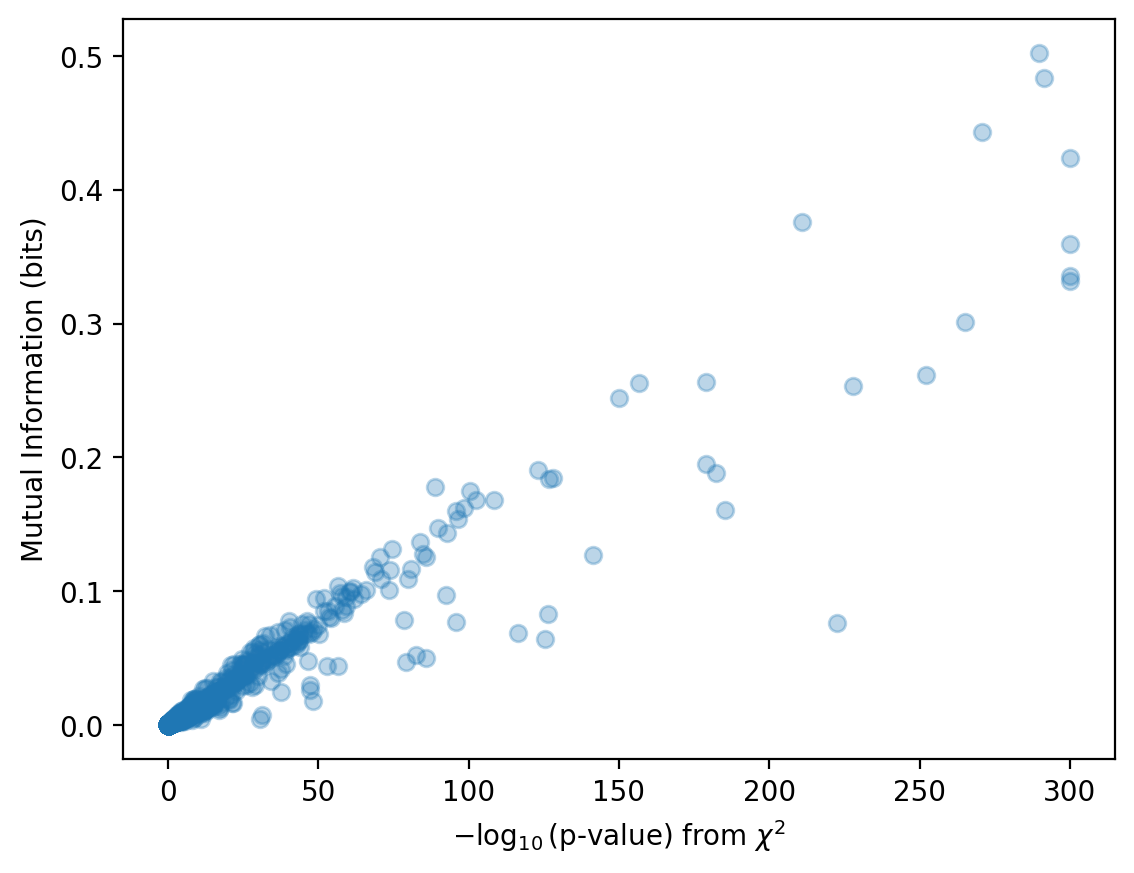

In [154]:
#| echo: false
#| label: fig-chi-vs-mi
#| fig-cap: "χ² significance vs MI effect size"

plt.scatter(df["minus_log10_p"], df["MI"], alpha=0.3)
plt.xlabel(r"$-\log_{10}(\text{p-value})$ from $\chi^2$")
plt.ylabel("Mutual Information (bits)")
plt.show()

First, we notice a positive relationship between the two metrics. It makes sense that when the mutual information between two phonemes increases, the p-value of the chi squared test would increase as well. Second, we notice that for most pairs, their p values (although mostly significative as seen in @fig-chi-distribution) and mutual information is low. We can conclude that although statistically significant relationships among phonemes exist, their are fairly weak.

We can also compare how the two methods sort the pairs. If the pairs with the highest values are the same in both cases, that would indicate that some phonemes do occur jointly with some others across most languages.

In [155]:
df_mi = pd.DataFrame(
    [(a, b, val) for (a, b), val in mutual_information.items()],
    columns=["Phoneme A", "Phoneme B", "Mutual Information (bits)"]
)

top15_mi = df_mi.sort_values(by="Mutual Information (bits)", ascending=False).head(15)

In [156]:
#| echo: false
#| label: tbl-15-li
#| tbl-cap: "Highest scoring pairs (mutual information)"

# Display the table
Markdown(top15_mi.to_markdown(index=False))

| Phoneme A   | Phoneme B   |   Mutual Information (bits) |
|:------------|:------------|----------------------------:|
| b           | ɡ           |                    0.502203 |
| e           | o           |                    0.483167 |
| ɔ           | ɛ           |                    0.44276  |
| ɭ           | ɳ           |                    0.423577 |
| b           | d           |                    0.375829 |
| ɪ           | ʊ           |                    0.359243 |
| ɳ           | ɻ           |                    0.335383 |
| ɭ           | ɻ           |                    0.331902 |
| ɳ           | ʈ           |                    0.301046 |
| c           | ɟ           |                    0.261875 |
| n           | t           |                    0.256056 |
| f           | v           |                    0.255819 |
| ɭ           | ʈ           |                    0.253606 |
| d           | ɡ           |                    0.244604 |
| ɻ           | ʈ           |                    0.195281 |

In [157]:
df_chi = pd.DataFrame(
    [(a, b, res['p']) for (a, b), res in chi2_results.items()],
    columns=["Phoneme A", "Phoneme B", "Chi squared test p-value"]
)

top15_chi = df_chi.sort_values(by="Chi squared test p-value", ascending=True).head(15)

In [158]:
#| echo: false
#| label: tbl-15-chi
#| tbl-cap: "Highest scoring pairs (chi squared test)"

Markdown(top15_chi.to_markdown(index=False))

| Phoneme A   | Phoneme B   |   Chi squared test p-value |
|:------------|:------------|---------------------------:|
| ɪ           | ʊ           |               0            |
| ɭ           | ɻ           |               0            |
| ɭ           | ɳ           |               0            |
| ɳ           | ɻ           |               0            |
| e           | o           |               5.74876e-292 |
| b           | ɡ           |               2.65706e-290 |
| ɔ           | ɛ           |               1.49586e-271 |
| ɳ           | ʈ           |               5.74781e-266 |
| c           | ɟ           |               6.61879e-253 |
| ɭ           | ʈ           |               1.48851e-228 |
| ħ           | ʕ           |               2.07763e-223 |
| b           | d           |               1.61494e-211 |
| i           | u           |               5.32627e-186 |
| k           | p           |               7.05611e-183 |
| n           | t           |               8.04282e-180 |

We remark that although the highest scoring pairs are not exactly symmetrical, most of the pairs with the highest mutual information are also those with the smallest p-values. Interestingly, concerning the basic vowel triangle, the only pair that appears is (u, i) in the 12th position of the chi squared test, but not in the mutual information table. Most pairs are pairs of consonants.

### Q10: concluding remarks

We have made some choices when preparing our data. First we sampled our inventories to have only one inventory per language. Second, we have greatly reduced our set of phonemes by (1) selecting only monophthong vowels, and (2) selecting only pulmonic consonants. First of all, we decided to reduce the set of phonemes (from around 2567 to 87) as computing pairs on the full set would mean computing metrics on 4 million pairs. Second, many phonemes present in the inventories were either composite sounds (diphthongs or triphthongs for the case of vowels) or base sounds with diacritics. As we can see on in @fig-phoneme-distribution, our filter has not altered the distribution of inventory sizes. Some types of phonemes (for example, clicks) are specific to a small set of languages, the same goes with some languages that have very complex vowel systems where a small set of base vowels are modified by a large number of diacritics. We argue that removing these features would reveal more of the underlying "universal" relationships, if those exist.

Our results show that the basic vowel triangle is not a universal feature, it is at most a very frequent one. Furthermore, the presence of one vowel from the set does not condition the presence of another, as seen by the chi-squared and mutual information tests. In general, most phonemes tend to appear with certain others, but these relationships are weak (significant p-values, but low mutual information). A natural continuation of these experiments would be to extend step by step the set of phonemes, as to uncover language-specific relationships. We would expect for example that ejectives would have higher mutual information among themselves, as most they are usually present as a system rather than isolated phonemes.

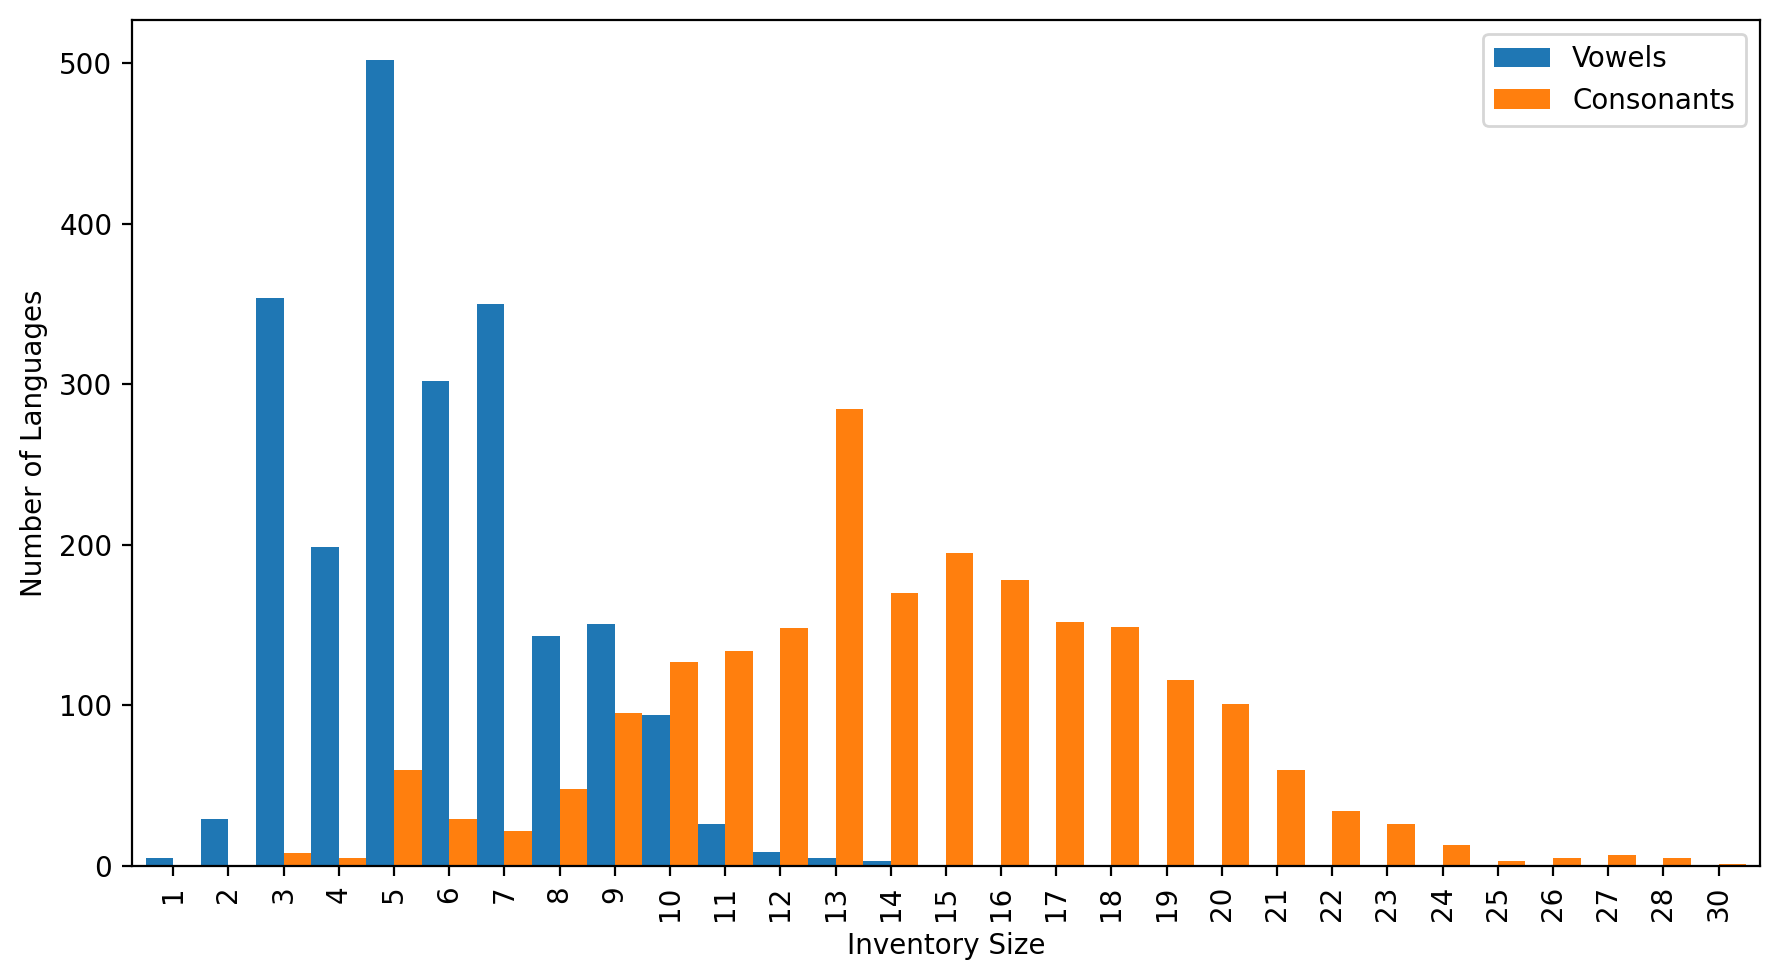

In [159]:
#| echo: false
#| label: fig-phoneme-distribution
#| fig-cap: "Distribution of phonetic inventory sizes across languages (base set of 87 phonemes)"

vowel_inventory_sizes = (
    filtered_data[filtered_data["SegmentClass"] == "vowel"]
    .groupby("Glottocode")["Phoneme"]
    .nunique()
)

# Compute consonant inventory sizes per Glottocode
consonant_inventory_sizes = (
    filtered_data[filtered_data["SegmentClass"] == "consonant"]
    .groupby("Glottocode")["Phoneme"]
    .nunique()
)

# Group together
phoneme_inventory_sizes = (
    pd.DataFrame({
        "Vowels": vowel_inventory_sizes.value_counts().sort_index(),
        "Consonants": consonant_inventory_sizes.value_counts().sort_index()
    })
    .fillna(0)
    .astype(int)
)

# Plot side-by-side bars
phoneme_inventory_sizes.plot(
    kind="bar",
    figsize=(9, 5),
    width=1,
    xlabel="Inventory Size",
    ylabel="Number of Languages"
)

plt.tight_layout()
plt.show()

## Discovering regularities in the corpus

:::{.callout-note}
## Instructions

The idea now is to see whether it is possible to identify other regularities from the data contained in the corpus. To do this, we will begin by looking at whether there are any frequent itemsets. A frequent itemset is a set of items (in our case, features or phonemes) that occur together in the data more often than a given minimum threshold. In the context of language inventories, an item could be the presence of a particular phoneme, and an itemset would be a combination of phonemes appearing in the same language. For example, the pair {[i], [u]} would form an itemset; if this pair appears in many languages, it can be considered a frequent itemset.

Frequent itemsets are evaluated using support, which measures how often the itemset appears relative to the total number of observations. Formally, the support of an itemset $X$ is defined as:

$$\text{support}(X) = \frac{\text{number of records (languages) containing } X}{\text{total number of records (languages)}}$$

Only itemsets whose support exceeds a chosen minimum support threshold (e.g., 10% of all languages) are considered frequent. This approach is commonly used in association-rule mining (such as the `Apriori` or `FP-Growth` algorithms) to uncover systematic co-occurrence patterns in large datasets. Once frequent itemsets have been identified, it is often useful to go further and examine association rules between items. Two key measures used for this purpose are confidence and lift.

Confidence measures how often items in $Y$ appear in transactions (or here, in languages) that already contain $X$. It reflects the conditional probability of $Y$ given $X$. Formally, for a rule $X \rightarrow Y$:

$$\text{confidence}(X \rightarrow Y) = \frac{\text{support}(X \cup Y)}{\text{support}(X)} = P(Y|X)$$

A high confidence value means that when $X$ occurs, $Y$ also occurs in a large proportion of cases.

Lift compares the observed co-occurrence of $X$ and $Y$ with what would be expected if they were statistically independent. It tells us whether the presence of $X$ increases ($\text{lift} > 1$), decreases ($\text{lift} < 1$), or has no effect on ($\text{lift} = 1$) the likelihood of $Y$. Formally:

$$\text{lift}(X \rightarrow Y) = \frac{\text{support}(X \cup Y)}{\text{support}(X) \times \text{support}(Y)}$$

Lift thus normalises confidence by the baseline frequency of $Y$.

In the context of phoneme inventories, high confidence for a rule such as $\{i\} \rightarrow \{u\}$ would mean that most languages containing /i/ also contain /u/.
A lift greater than 1 would indicate that /i/ and /u/ co-occur more often than expected by chance.

:::

### Q11: for each possible itemset of size 1, compute *support*

In [160]:
def compute_phoneme_support(data: pd.DataFrame):
    n = data['Glottocode'].nunique()
    counts = data.groupby('Phoneme')['Glottocode'].nunique()
    support = counts / n
    support.name = "Support" 
    return support.sort_values(ascending=False).reset_index()

support_size_1 = compute_phoneme_support(filtered_data)

In [161]:
#| echo: false
#| label: tbl-support
#| tbl-cap: "Support for itemsets of size 1"

Markdown(support_size_1.head(15).to_markdown(index=False))

| Phoneme   |   Support |
|:----------|----------:|
| m         |  0.965993 |
| i         |  0.933824 |
| k         |  0.905331 |
| j         |  0.899357 |
| u         |  0.891544 |
| a         |  0.884651 |
| p         |  0.853401 |
| n         |  0.794577 |
| t         |  0.710938 |
| l         |  0.679688 |
| s         |  0.665901 |
| e         |  0.642923 |
| ŋ         |  0.636949 |
| o         |  0.630055 |
| b         |  0.621324 |

### Q12: for all itemset of size 2, compute *support*

We can adapt the previous function to take `size` as an argument.

In [162]:
#| output: false

import itertools

def compute_support_v2(matrix: pd.DataFrame, size):
    combinations = list(itertools.combinations(matrix.columns, size))
    n = matrix.shape[0]
    support = {}

    for itemset in tqdm(combinations, desc=f"Computing size {size} support"):
        mask = matrix[list(itemset)].all(axis=1)
        support[itemset] = mask.sum() / n

    support = pd.Series(support, name="Support").sort_values(ascending=False)
    support.index = pd.MultiIndex.from_tuples(
        support.index, names=[f"Phoneme {i+1}" for i in range(size)]
    )

    return support.reset_index()

support_size_2 = compute_support_v2(matrix, 2)

Computing size 2 support: 100%|██████████| 3741/3741 [00:00<00:00, 3973.92it/s]


We can compute itemsets of as many sizes as we want.

In [163]:
#| echo: false
#| label: tbl-support-2
#| tbl-cap: "Support for itemsets of size 2"

Markdown(support_size_2.head(15).to_markdown(index=False))

| Phoneme 1   | Phoneme 2   |   Support |
|:------------|:------------|----------:|
| i           | m           |  0.901654 |
| i           | u           |  0.880974 |
| j           | m           |  0.873162 |
| k           | m           |  0.873162 |
| m           | u           |  0.861213 |
| i           | k           |  0.852022 |
| a           | m           |  0.851103 |
| a           | i           |  0.840533 |
| i           | j           |  0.839154 |
| k           | p           |  0.836857 |
| m           | p           |  0.825827 |
| j           | k           |  0.814798 |
| k           | u           |  0.8125   |
| a           | k           |  0.806066 |
| j           | u           |  0.803768 |

### Q13: define the *frequent* itemsets as those who exceed the *minimum support threshold*

In [164]:
def frequent_itemsets(support_table: pd.DataFrame, threshold):
    return support_table[support_table["Support"] > threshold]

frequent_itemsets_size_1 = frequent_itemsets(support_size_1, 0.1)
frequent_itemsets_size_2 = frequent_itemsets(support_size_2, 0.1)

In [165]:
#| echo: false

print(f"Number of 'frequent' itemsets of size 1: {len(frequent_itemsets_size_1)}")
print(f"% of 'frequent' itemsets of size 1 amongst total: {len(frequent_itemsets_size_1)/len(support_size_1)*100:.2f}%")
print()
print(f"Number of 'frequent' itemsets of size 2: {len(frequent_itemsets_size_2)}")
print(f"% of 'frequent' itemsets of size 2 amongst total: {len(frequent_itemsets_size_2)/len(support_size_2)*100:.2f}%")

Number of 'frequent' itemsets of size 1: 42
% of 'frequent' itemsets of size 1 amongst total: 48.28%

Number of 'frequent' itemsets of size 2: 539
% of 'frequent' itemsets of size 2 amongst total: 14.41%


The larger the itemsets, the smaller the set of itemsets who exceed the defined minimum support threshold.

### Q14: identify frequent itemsets of size 2

In [166]:
#| echo: false
#| label: tbl-frequent-itemsets
#| tbl-cap: "Frequent itemsets of size 2 (threshold = 0.1)"

Markdown(frequent_itemsets_size_2.head(15).to_markdown(index=False))

| Phoneme 1   | Phoneme 2   |   Support |
|:------------|:------------|----------:|
| i           | m           |  0.901654 |
| i           | u           |  0.880974 |
| j           | m           |  0.873162 |
| k           | m           |  0.873162 |
| m           | u           |  0.861213 |
| i           | k           |  0.852022 |
| a           | m           |  0.851103 |
| a           | i           |  0.840533 |
| i           | j           |  0.839154 |
| k           | p           |  0.836857 |
| m           | p           |  0.825827 |
| j           | k           |  0.814798 |
| k           | u           |  0.8125   |
| a           | k           |  0.806066 |
| j           | u           |  0.803768 |

What we observe is that the most frequent vowels and consonants (the top 3 for the vowels and top 4 for the consonants) are also those who come up in the frequent itemsets of size 2. This result seems unsurprising, as the most frequent phonemes have a higher chance to appear with other frequent phonemes.

### Q15: for at least one itemset, compute *confidence* and *lift*

First we define a function to compute confidence and lift.

In [167]:
def confidence_and_lift(pairs: pd.DataFrame, singles: pd.DataFrame, X: str, Y: str):

    # Extract the support values for the itemsets
    sXY = pairs.loc[(pairs["Phoneme 1"] == X) & (pairs["Phoneme 2"] == Y), "Support"].item()
    sX = singles.loc[singles["Phoneme"] == X, "Support"].item()
    sY = singles.loc[singles["Phoneme"] == Y, "Support"].item()

    # Compute confidence and lift
    confidence = sXY / sX
    lift = sXY / (sX * sY)

    return {(X, Y) :{"confidence": confidence, "lift": lift}}

We can apply.

In [168]:
#| echo: false

ai = confidence_and_lift(frequent_itemsets_size_2, frequent_itemsets_size_1, "a", "i")
au = confidence_and_lift(frequent_itemsets_size_2, frequent_itemsets_size_1, "a", "u")
iu = confidence_and_lift(frequent_itemsets_size_2, frequent_itemsets_size_1, "i", "u")
mv = confidence_and_lift(frequent_itemsets_size_2, frequent_itemsets_size_1, "m", "v")
ox = confidence_and_lift(frequent_itemsets_size_2, frequent_itemsets_size_1, "o", "x")

print(ai)
print(au)
print(iu)
print(mv)
print(ox)

{('a', 'i'): {'confidence': 0.9501298701298702, 'lift': 1.0174619081705696}}
{('a', 'u'): {'confidence': 0.9049350649350649, 'lift': 1.0150199491230418}}
{('i', 'u'): {'confidence': 0.9434055118110236, 'lift': 1.0581703060313337}}
{('m', 'v'): {'confidence': 0.2711703139866794, 'lift': 1.012121103319064}}
{('o', 'x'): {'confidence': 0.16557257476294676, 'lift': 0.9607624604911259}}


### Q16: interpretation of results

Looking at the confidence values of the basic vowel triangle, we are unsurprised to see that their confidence values are high, it reflects their high frequencies overall. But looking at their lift values (their co-occurrence if they were independent), we see that although the values are positive, they are close to zero, indicating independence. The effect we are seeing is mostly due to their individual high frequencies.

Additionally, if we compare the basic vowel triangle with a pair of consonants, one being a "frequent" item and not the other, we cans see that the confidence decreases drastically. Furthermore, taking an itemset where both items are not considered as "frequent", not only the confidence decreases, but also the lift is below 1, indicating that the likelihood of $Y$ decreases with the presence of $X$.

Therefore, the most common phoneme combinations are those involving already frequent phonemes. Furthermore, the lift values indicate that these associations are the product of the individual frequencies and not of dependence between the items (lift values being close to zero).

---

:::{.callout-note}
## Instructions

To go beyond manually calculating support for pairs of phonemes, you can use an existing implementation of the _Apriori_ algorithm, which efficiently discovers frequent itemsets of any size. One convenient implementation is provided in the Python library `mlxtend` (*Machine Learning Extensions*). Its `apriori` function takes a binary matrix (rows = languages, columns = presence/absence of phonemes) and returns all itemsets above a specified minimum support threshold. The same library also includes an `association_rules` function for computing confidence and lift automatically.

:::

### Q17: prepare the dataset as a binary matrix

In [169]:
#| echo: false
#| label: tbl-matrix
#| tbl-cap: "Incidence matrix of phonemes in world languages"

display(matrix)

Phoneme,a,b,c,d,e,f,h,i,j,k,...,ʒ,ʔ,ʕ,ʙ,ʝ,ʟ,β,θ,χ,ⱱ
Glottocode,,,,,,,,,,,,,,,,,,,,,
aari1239,1,1,0,0,0,1,0,0,1,1,...,1,1,0,0,0,0,0,0,0,0
abar1238,1,1,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
abau1245,0,0,0,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
abid1235,1,1,0,1,1,1,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
abip1241,1,0,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zoee1240,1,1,0,1,1,0,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
zoog1238,1,1,0,1,1,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
zulg1242,1,1,0,1,0,1,1,0,1,1,...,0,1,0,0,0,0,0,0,0,0


### Q18: use the `apriori` function to identify frequent itemsets of size 2

In [170]:
from mlxtend.frequent_patterns import apriori

apriori_frequent_itemsets = apriori(matrix.astype(bool), min_support=0.1, use_colnames=True, max_len=2)

In [171]:
#| echo: false
#| label: tbl-apriori
#| tbl-cap: "Support for itemsets of size 2 using the apriori algorithm"

display(apriori_frequent_itemsets[apriori_frequent_itemsets['itemsets'].apply(lambda x: len(x) == 2)].sort_values(by='support', ascending=False).reset_index(drop=True))

,support,itemsets
0,0.901654,"(m, i)"
1,0.880974,"(u, i)"
2,0.873162,"(m, j)"
3,0.873162,"(m, k)"
4,0.861213,"(m, u)"
...,...,...
534,0.101562,"(ɟ, n)"
535,0.101103,"(ɪ, u)"
536,0.100643,"(l, ʊ)"
537,0.100643,"(ʃ, ɾ)"


### Q19: export the itemsets

In [172]:
apriori_itemsets_size_2 = apriori_frequent_itemsets[apriori_frequent_itemsets['itemsets'].apply(lambda x: len(x) == 2)].sort_values(by='support', ascending=False).reset_index(drop=True)

### Q20: using the `association_rules` function, compute the confidence and lift for at least two association rules

In [173]:
from mlxtend.frequent_patterns import association_rules

association_metrics = association_rules(apriori_frequent_itemsets, metric="confidence")

In [174]:
#| echo: false
#| label: tbl-eon
#| tbl-cap: "Association rules between /ɛ/ and /ɔ/"

pair1 = association_metrics[(association_metrics['antecedents'] == {'ɛ'}) & (association_metrics['consequents'] == {'ɔ'})].loc[:, ['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift']]
display(pair1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
359,(ɛ),(ɔ),0.365809,0.352482,0.302849,0.827889,2.348745


In [175]:
#| echo: false
#| label: tbl-st
#| tbl-cap: "Association rules between /s/ and /t/"


pair2 = association_metrics[(association_metrics['antecedents'] == {'s'}) & (association_metrics['consequents'] == {'t'})].loc[:, ['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift']]


display(pair2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
319,(s),(t),0.665901,0.710938,0.539982,0.810904,1.140612


We picked two association rules, one amongst vowels and another amongst consonants. The association rule [ɛ] $\to$ [ɔ] is composed of two open-mid sounds, the antecedent is fronted and unrounded while the consequent is back and rounded. We can see that the lift score is very high indicating that having a fronted open-mid vowel strongly increases the likelihood to have a back open-mid vowel.

The second association rule [s] $\to$ [t] is between two voiceless alveolar consonants. The antecedent is a fricative while the consequent is a plosive. Here the lift value is also positive but much lower than the previous association rule.

Although the confidence values of both rules are relatively similar, we notice that the support values are not. Indeed the support values for the antecedent and consequent of the first association rule are low (around 0.35) while being much larger for the second association rule (around 0.66 and 0.7 respectively). This "frequency" effect, can partly explain why the lift value for the second association rule is lower: the two items appear together not because one is dependent on the other but because they are relatively frequent phonemes. On the other hand, the low frequencies of the phonemes of the first association rule indicate that the presence of one strongly depends on the presence of the other.